In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Define file paths
base_path = '/g/data/ia39/ncra/ocean/peacey/'
file_template = base_path + '{variable}_climatology_{period}.nc'
variables = ['OAR', 'PH', 'temp']
periods = ['PI', 'current', 'GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']


In [4]:
# Function to load data and compute annual mean
def load_and_annual_mean(file_path, var):
    """
    Load a dataset from a NetCDF file and compute the annual mean for a specified variable.
    
    Parameters:
        file_path (str): Path to the NetCDF file containing the dataset.
        var (str): Name of the variable in the dataset for which the annual mean is to be computed.
        
    Returns:
        annual_mean (xarray.DataArray): The annual mean values of the specified variable, averaged over each month.

    Notes:
        The function uses xarray to open the dataset and assumes the dataset has a 'month' dimension.
        The mean is calculated by grouping data by the 'month' dimension and then averaging over it.
    """
    ds = xr.open_dataset(file_path)
    annual_mean = ds[var].groupby('month').mean(dim='month')
    return annual_mean

In [5]:
# Load datasets and compute annual means
annual_means = {}
for period in periods:
    for var in variables:
        file_path = file_template.format(variable=var, period=period)
        annual_means[(var, period)] = load_and_annual_mean(file_path, var)

In [6]:
def plot_variable(data, variable, title, levels, contour_levels=None, 
                  lon_name='XT_OCEAN', lat_name='YT_OCEAN'):
    """
    Plots a given variable on a map projection for the southern hemisphere and saves the plot to a PDF.
    
    Parameters:
        data (xarray.Dataset or xarray.DataArray): The data to be plotted, 
            containing the variable of interest along with latitude and longitude coordinates.
        variable (str): The name of the variable to be plotted. This will be used for the colorbar label.
        title (str): The title of the plot.
        levels (list or array-like): The levels for the color scale of the plot (vmin and vmax will be set to the first and last levels).
        contour_levels (list or array-like, optional): The levels for contour lines to be added on top of the plot. If None, no contour lines will be added.
        lon_name (str, optional): The name of the longitude coordinate in the data. Default is 'XT_OCEAN'.
        lat_name (str, optional): The name of the latitude coordinate in the data. Default is 'YT_OCEAN'.
    
    Returns:
        None
    """
    
    fig, ax = plt.subplots(figsize=(12, 6), 
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    fig.suptitle(title, fontsize=20)

    # Extract coordinates
    lon = data[lon_name]
    lat = data[lat_name]
    
    # Ensure data dimensions match the coordinates
    data_2d = data.squeeze().mean(dim='month')

    
    # Plotting the data
    img = ax.pcolormesh(lon, lat, data_2d, cmap='viridis', 
                        transform=ccrs.PlateCarree(), vmin=levels[0], vmax=levels[-1])
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([0, 360, -90, 0], crs=ccrs.PlateCarree())  # Southern Hemisphere

    # Add contour lines if provided
    if contour_levels is not None:
        contour = ax.contour(lon, lat, data_2d, levels=contour_levels, 
                             colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
        ax.clabel(contour, inline=True, fontsize=8)

    # Colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(f'{variable}')

    # Set ticks and labels for latitude and longitude
    ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    ax.set_xticklabels(['', '60°E', '120°E', '180°', '120°W', '60°W', ''])
    ax.set_yticks(np.arange(-90, 1, 30), crs=ccrs.PlateCarree())
    ax.set_yticklabels(['90°S', '60°S', '30°S', '0°'])

    #plt.savefig(pdf, format="pdf")  # Save current plot to PDF
    plt.show()
    

# Define levels for color bar and contour lines
levels = np.linspace(0.5, 3.5, 7) 
contour_levels = [1.0]

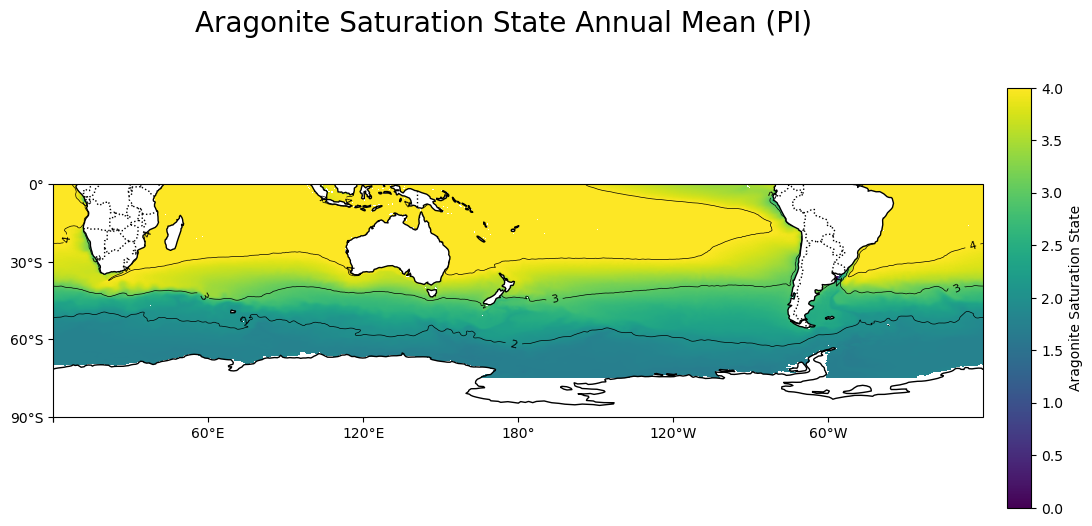

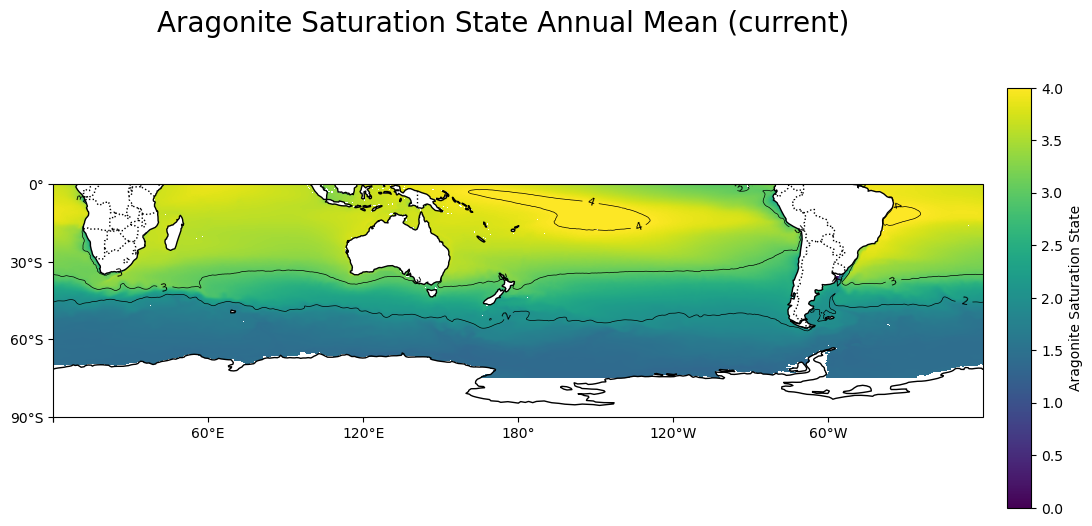

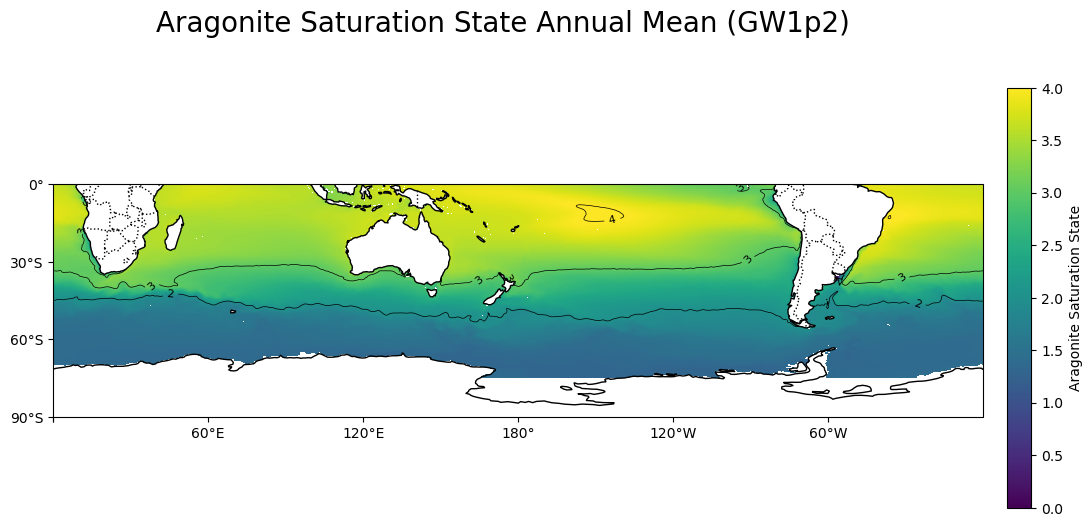

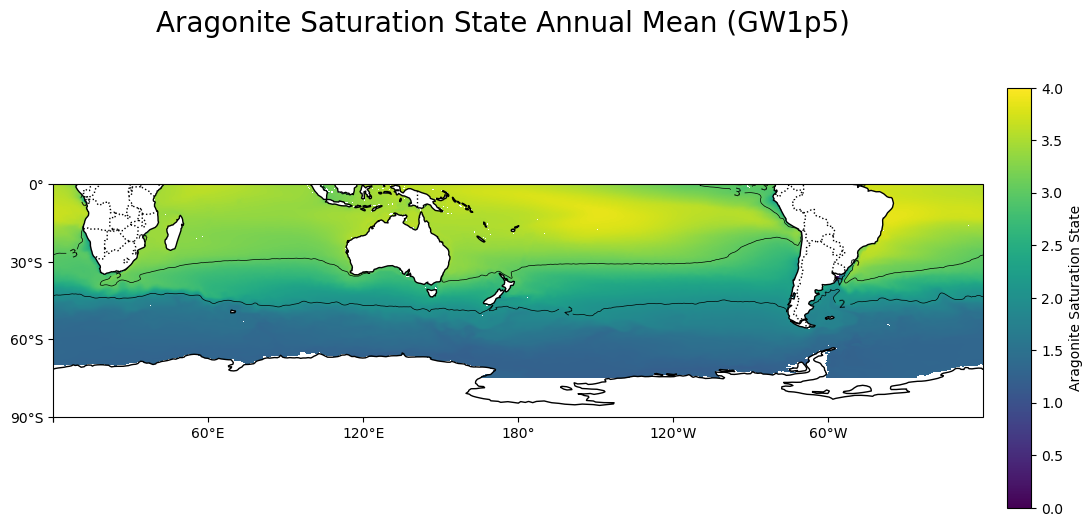

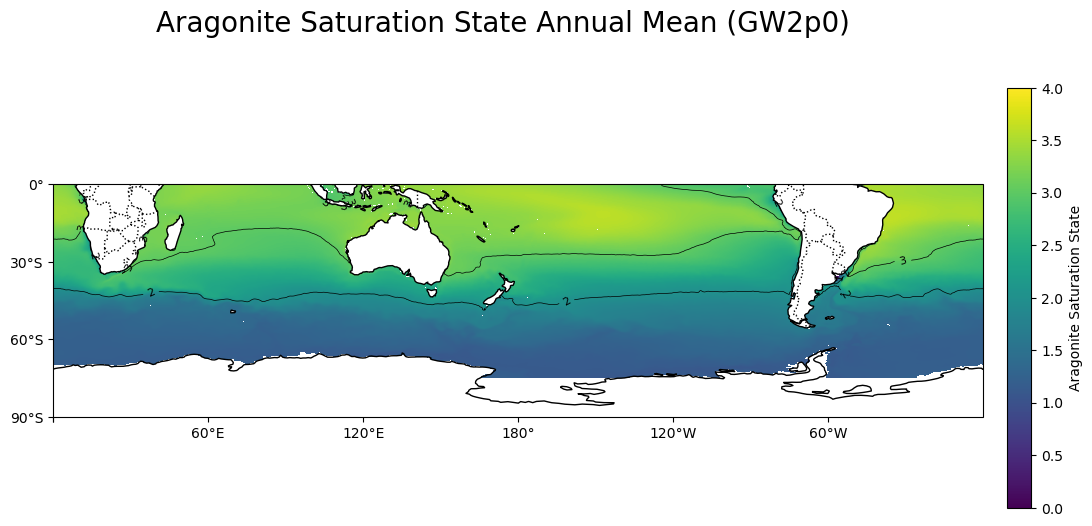

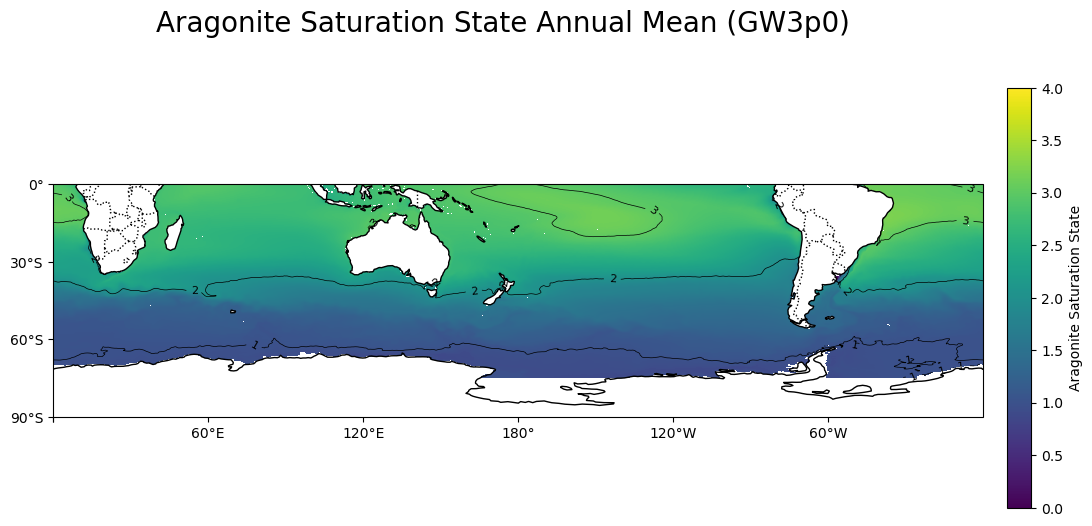

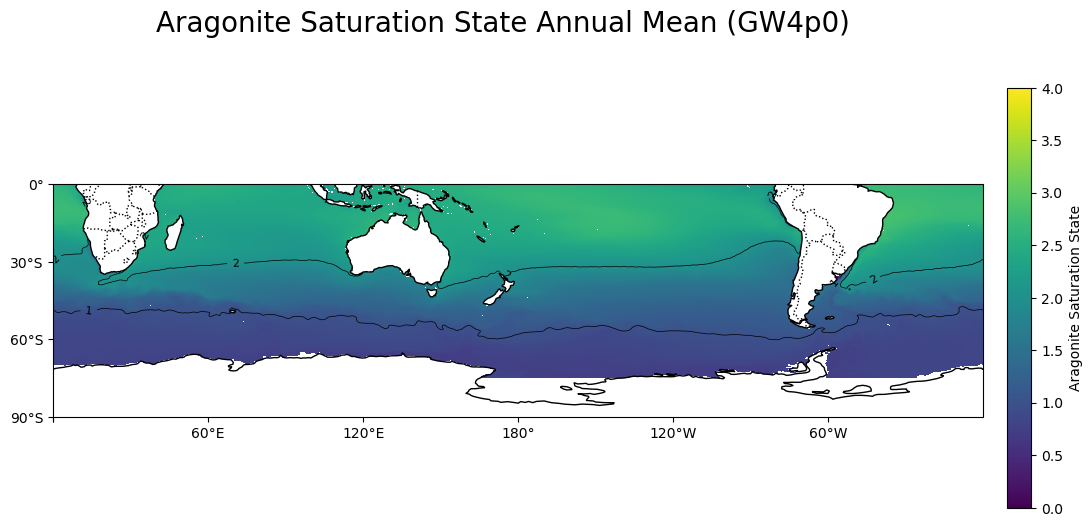

In [7]:
# Plotting aragonite saturation state
for period in periods:
    plot_variable(annual_means[('OAR', period)], 'Aragonite Saturation State', 
                  f'Aragonite Saturation State Annual Mean ({period})', levels=np.linspace(0, 4, 21), contour_levels=[1,2,3,4])

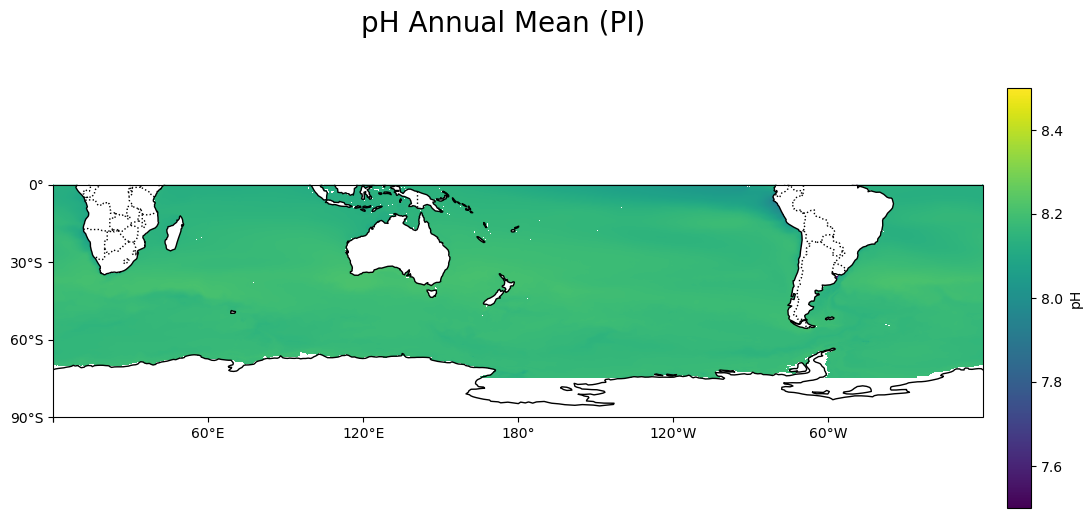

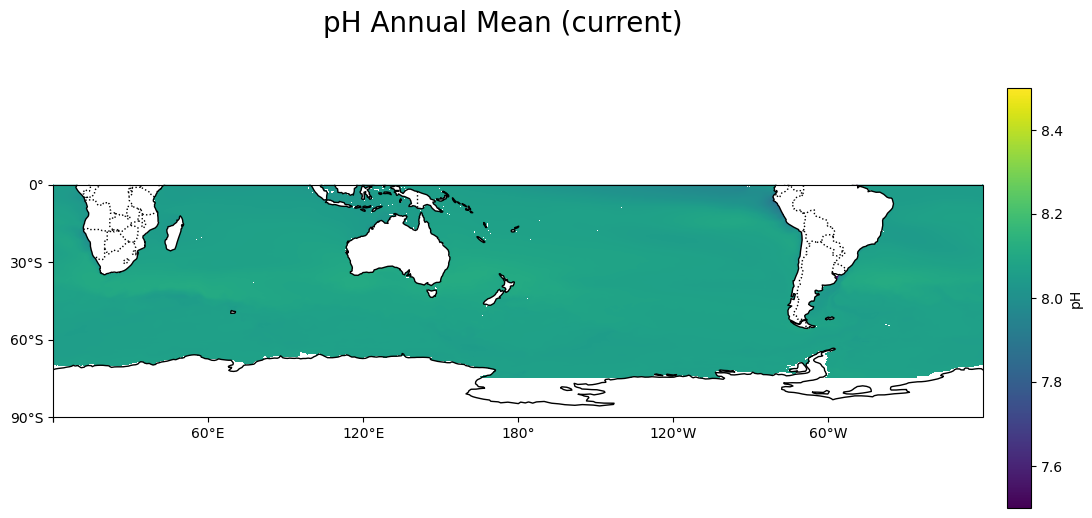

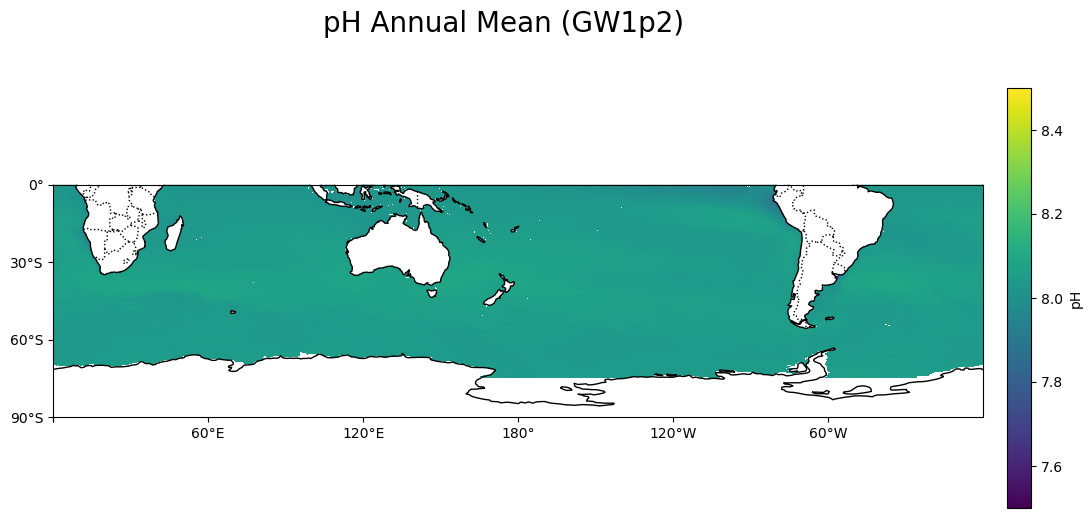

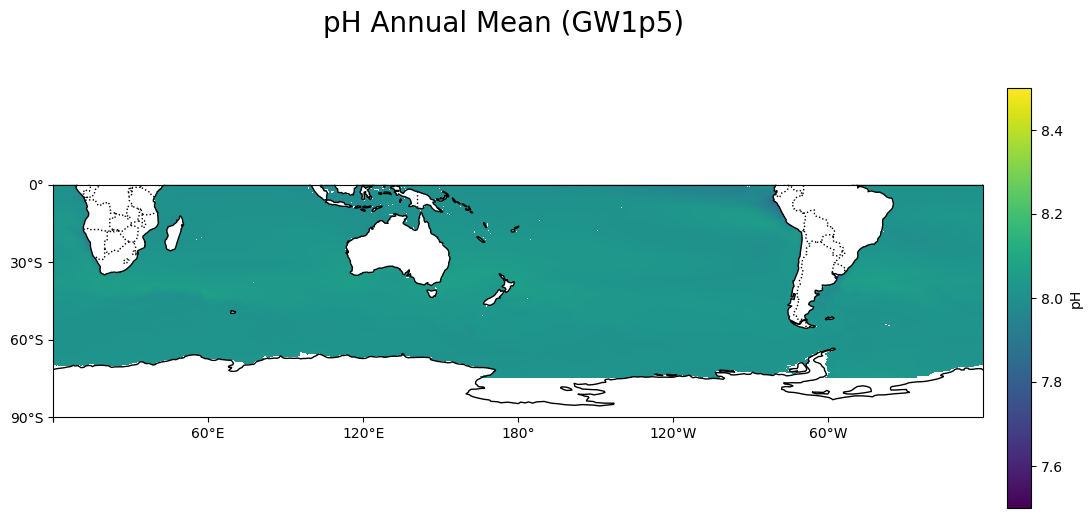

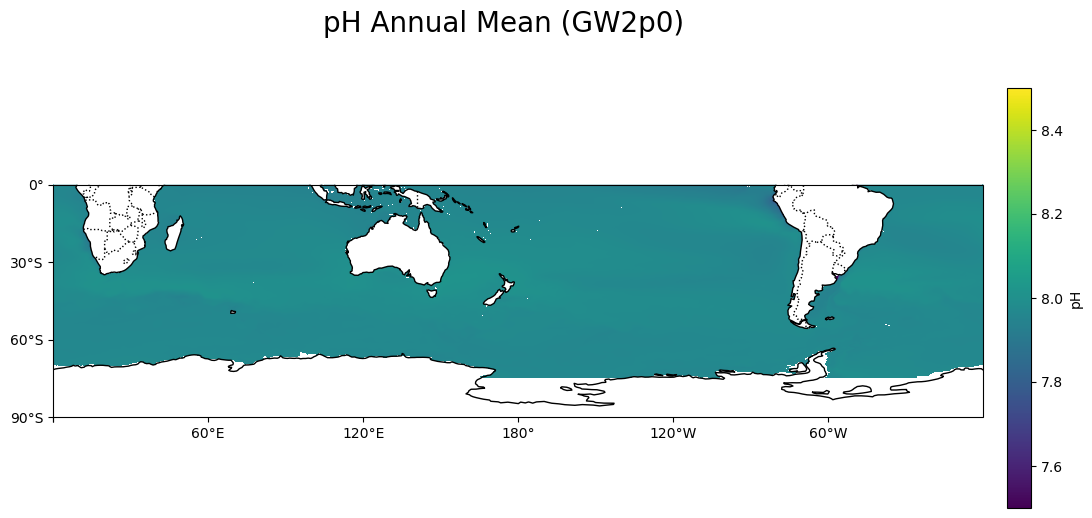

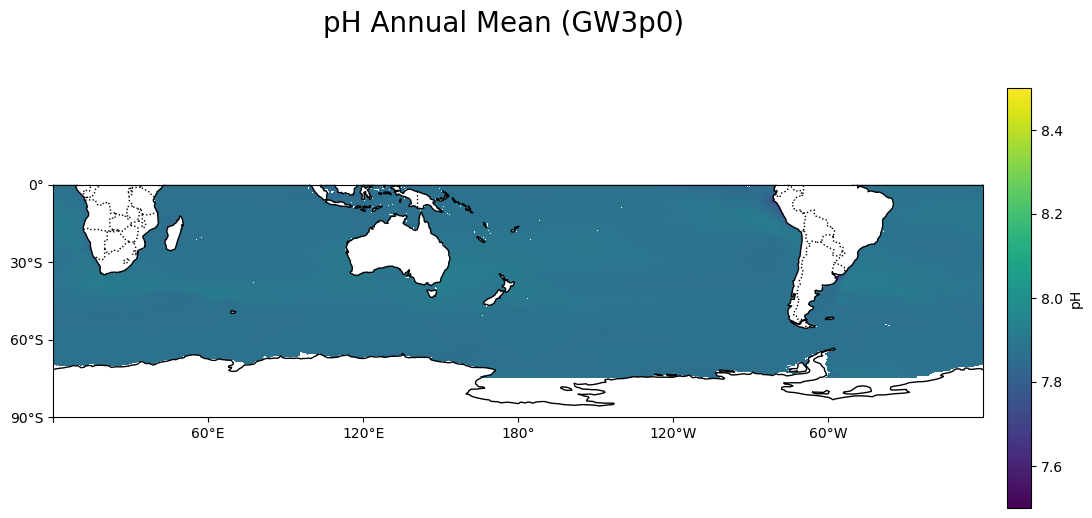

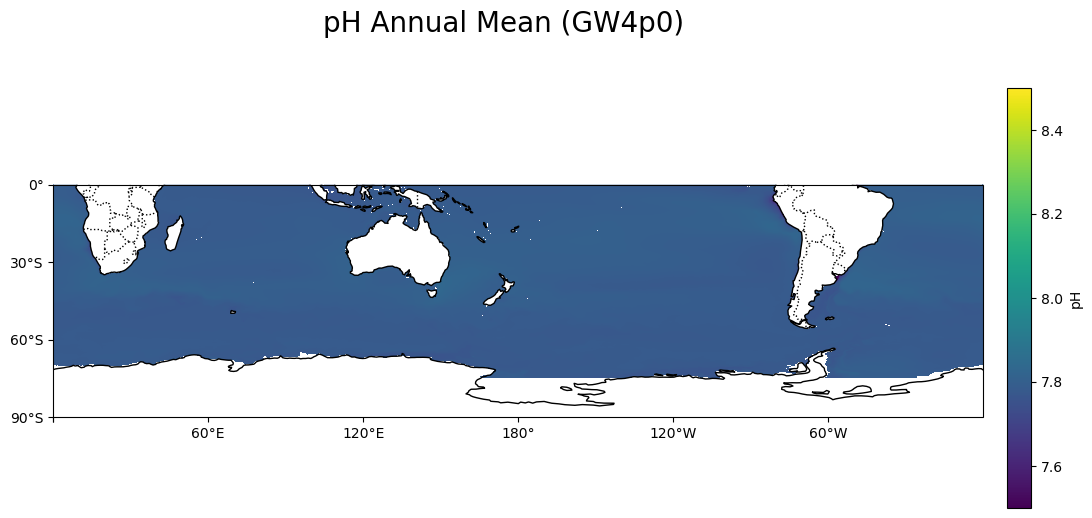

In [8]:
# Plotting pH for each period
for period in periods:
    plot_variable(annual_means[('PH', period)], 'pH', f'pH Annual Mean ({period})', levels=np.linspace(7.5, 8.5, 21))

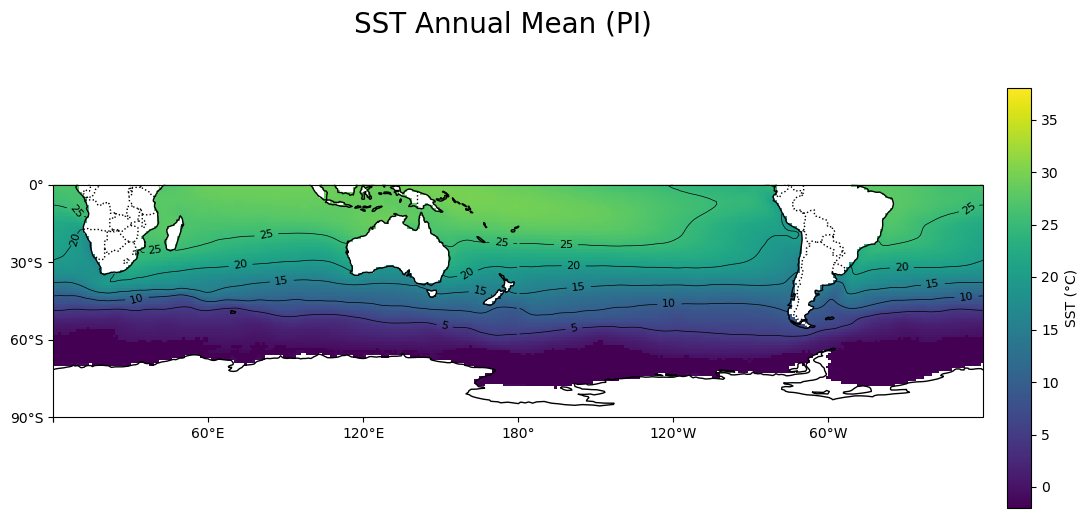

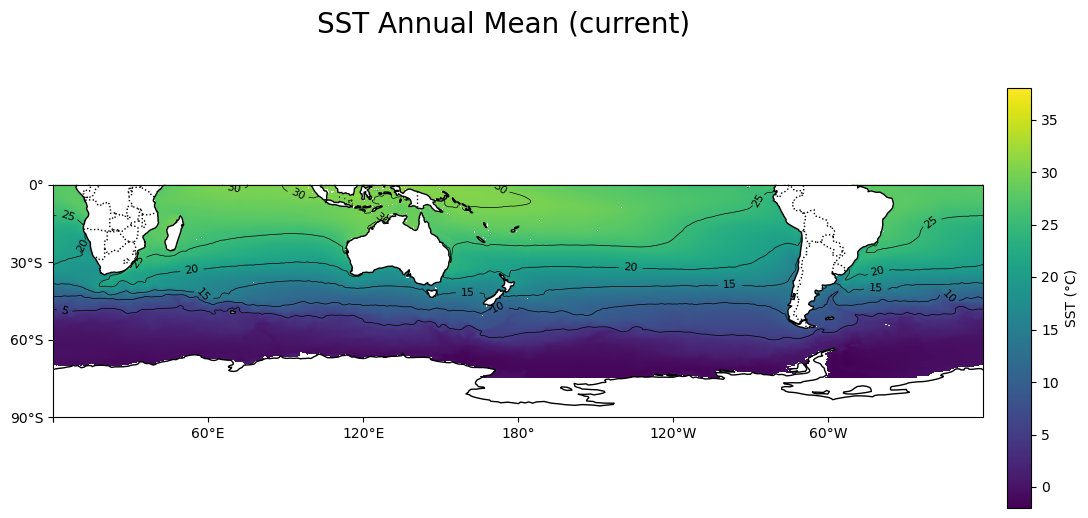

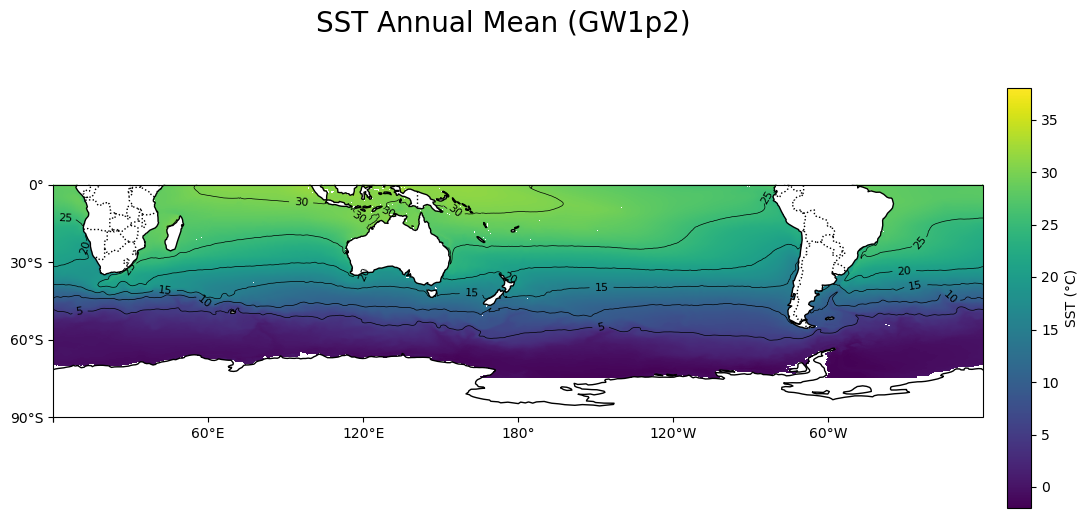

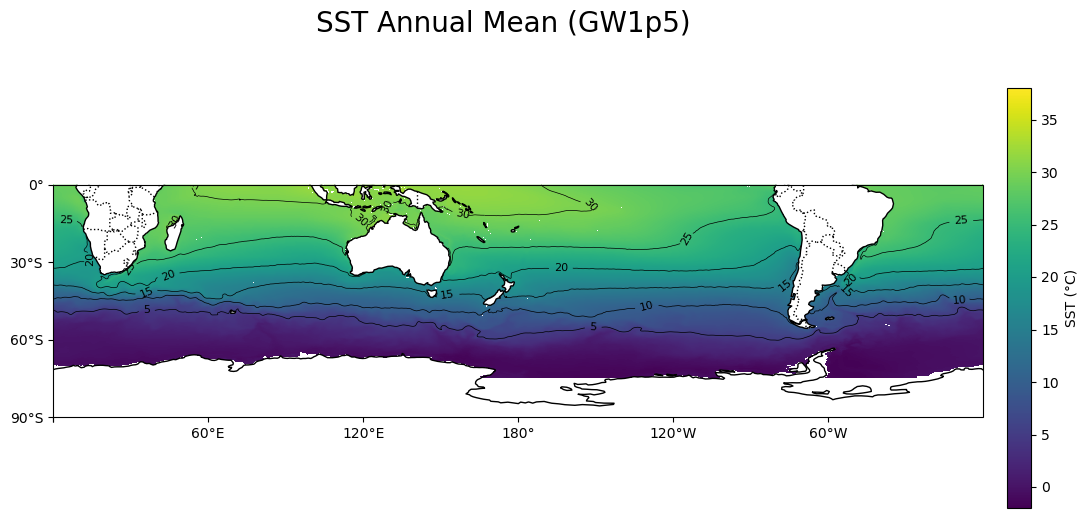

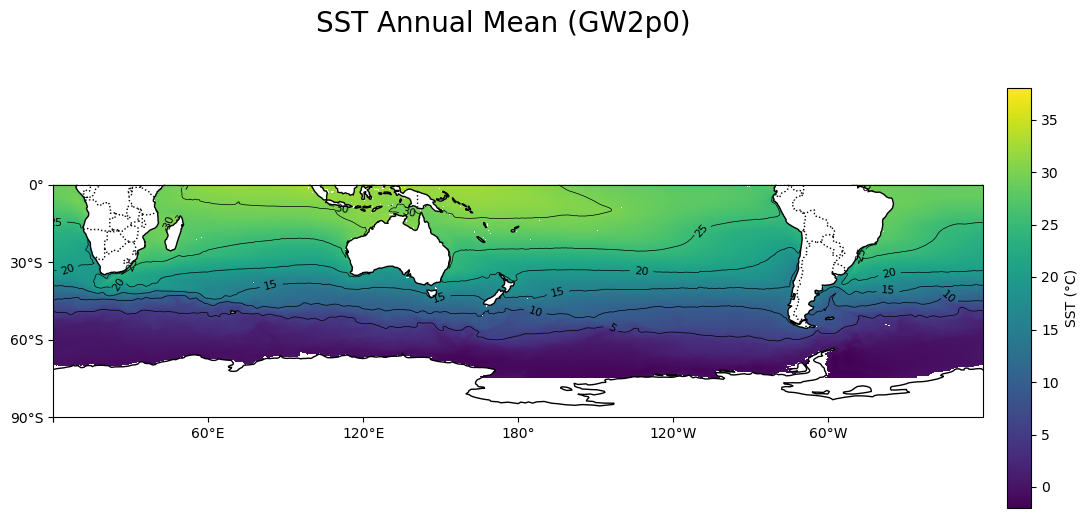

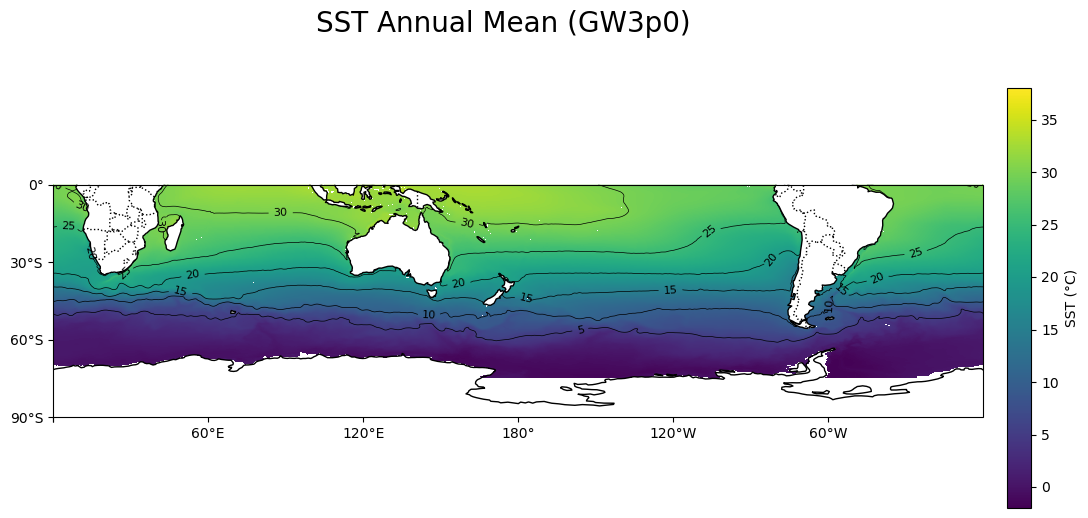

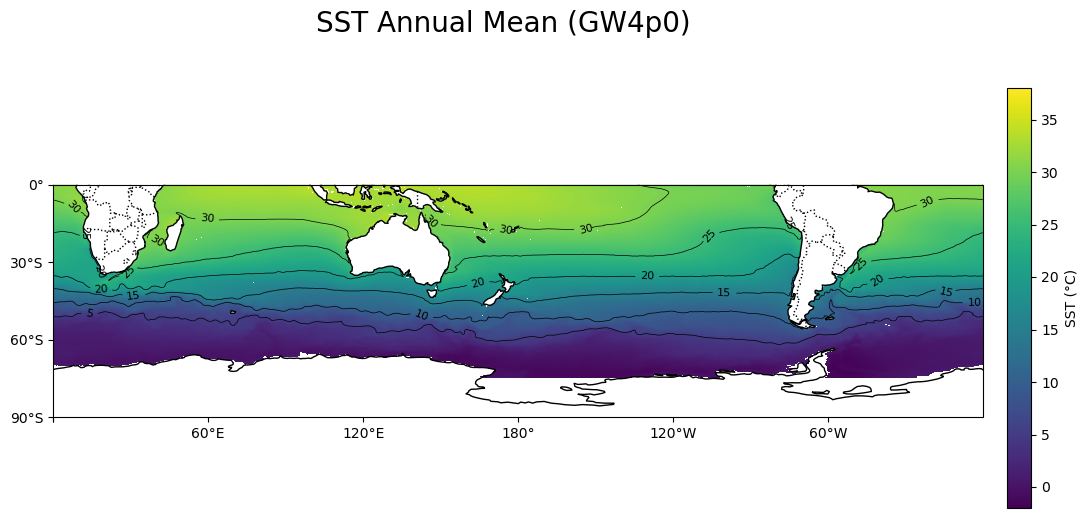

In [9]:
# Plotting temp for each period
for period in periods:
    if period == 'PI':
        plot_variable(annual_means[('temp', period)], 'SST (°C)', f'SST Annual Mean ({period})', 
                      np.linspace(-2.0, 38, 21), lon_name = 'longitude', lat_name = 'latitude', contour_levels=[5, 10, 15, 20, 25, 30, 35])
    else:
        plot_variable(annual_means[('temp', period)], 'SST (°C)', f'SST Annual Mean ({period})', 
                      np.linspace(-2.0, 38, 21), lon_name = 'xt_ocean', lat_name = 'yt_ocean', contour_levels=[5, 10, 15, 20, 25, 30, 35])